In [1]:
#install required packages
import sys
!pip install atlasopenmagic
from atlasopenmagic import install_from_environment
install_from_environment()

Installing packages: ['aiohttp>=3.9.5', 'atlasopenmagic>=1.0.1', 'awkward>=2.6.7', 'awkward-pandas>=2023.8.0', 'coffea~=0.7.0', 'hist>=2.8.0', 'ipykernel>=6.29.5', 'jupyter>=1.0.0', 'lmfit>=1.3.2', 'matplotlib>=3.9.1', 'metakernel>=0.30.2', 'notebook<7', 'numpy>=1.26.4', 'pandas>=2.2.2', 'papermill>=2.6.0', 'pip>=24.2', 'scikit-learn>=1.5.1', 'uproot>=5.3.10', 'uproot3>=3.14.4', 'fsspec-xrootd>=0.5.1', 'jupyterlab_latex~=3.1.0', 'vector>=1.4.1']
Installation complete. You may need to restart your Python environment for changes to take effect.


In [1]:
import uproot # For reading ROOT files efficiently
import awkward as ak # To represent nested data in columnar format
import pandas as pd # For dataframes, a format widely used in python
import numpy as np # For numerical calculations such as histogramming
import time # For timing operations and adding delays if needed
import matplotlib.pyplot as plt # For creating plots and visualizations
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import atlasopenmagic as atom  # Provides access to ATLAS Open Data metadata and streaming URLs
from concurrent.futures import ProcessPoolExecutor, as_completed # Enables parallel execution for faster processing of large datasets
# Filter warnings that otherwise appear in output. These are normal in the running of this notebook.
import warnings

warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="overflow encountered in power")
warnings.filterwarnings("ignore", message="overflow encountered in multiply", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")


In [2]:
# Integrated luminosity in inverse picobarns
lumi = 36000.

# Fraction of events to process
fraction = 0.25

In [3]:
atom.set_release('2025e-13tev-beta')

mc_defs = {
    r'ttbar_Ztt':    {'dids': [410470,700901, 700902],},
    r'tautau': {'dids': [346919, 346923, 346927]},
    r'Higgs':  {'dids': [345120, 345121, 345122, 345123]},
}

mc_samples   = atom.build_mc_dataset(mc_defs,   skim='2J2LMET30', protocol='https')
data_samples_1 = atom.build_data_dataset('2J2LMET30', name="Data", protocol='https')

samples = {**data_samples_1, **mc_samples}

variables = ["mcWeight", "ScaleFactor_DiTauTRIGGER", "trigE", "trigDT", "lep_n", "lep_pt","ScaleFactor_BTAG","lep_isMediumID",
            "lep_eta", "lep_phi", "lep_charge", "lep_type","tau_n","tau_pt", "tau_e", "tau_eta", "tau_phi", "met", "met_phi", "sum_of_weights", "ScaleFactor_FTAG","lep_isLooseIso",
            "xsec", "jet_pt", "jet_btag_quantile", "jet_n", "jet_eta", "jet_phi", "jet_e","jet_jvt","lep_isTrigMatched",
            "lep_type", "lep_e", "eventNumber", "ScaleFactor_ELE", "ScaleFactor_TAU","ScaleFactor_PILEUP","filteff", "kfac"]


Active release set to: 2025e-13tev-beta. Metadata cache cleared.
Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.


In [4]:
def calc_weight(data):
    weight_list =( data["ScaleFactor_TAU"] * data["ScaleFactor_DiTauTRIGGER"] * data["ScaleFactor_PILEUP"] *
             ( data["ScaleFactor_BTAG"] * data["mcWeight"] / data["sum_of_weights"]) * (data["xsec"] * data["filteff"] * data["kfac"] * lumi) )
    return weight_list

In [5]:
def cut_trig(trigDT):
    return trigDT

In [6]:
def two_lep(tau_n):
    return tau_n == 2

In [7]:
def cut_lep_pt(tau_pt):
    return ak.sum(tau_pt > 20, axis=1) >= 2

In [8]:
def cut_met_et(met_et):
    return met_et > 20

In [9]:
def cut_charge(charge):
    return ak.sum(charge, axis=1) == 0

In [10]:
def cut_type(type1):
    return ak.sum(type1 == 15, axis=1) == 2

In [11]:
def cut_jet(E,pt,b_tag):
  E_check = ak.sum(E >= 30 , axis=1) >= 2
  pt_check = ak.sum(pt >= 30, axis=1) >= 2
  btag_check = ak.sum(b_tag>=3, axis=1) < 1
  return (pt_check) & (E_check) & (btag_check)

In [12]:
def cut_DR(eta,phi,eta_M,phi_M):

    Dphi1 = np.arccos( np.cos(phi -  phi_M[:,0]) )
    Dphi2 = np.arccos( np.cos(phi -  phi_M[:,1]) )

    Deta1 = eta - eta_M[:,0]
    Deta2 = eta - eta_M[:,1]

    DR_M1 = np.sqrt((Deta1)**2 + (Dphi1)**2)
    DR_M2 = np.sqrt((Deta2)**2 + (Dphi2)**2)

    DR_M1_check = ak.sum(DR_M1 >= 0.4, axis=1) >= 1
    DR_M2_check = ak.sum(DR_M2 >= 0.4, axis=1) >= 1

    return (DR_M1_check) & (DR_M2_check)

In [13]:
def cut_VBF(jet_E,pt,eta,phi):
    jet_px = pt * np.cos(phi)
    jet_py = pt * np.sin(phi)
    jet_pz = pt / np.tan(2.0 * np.arctan( np.exp( -eta ) ) )

    # Helper function to create combinations of jets
    def combo(list_1):
        jets_pairs = ak.combinations(list_1, 2, fields=['List1', 'List2'])
        sum_List = jets_pairs['List1'] + jets_pairs['List2']
        return sum_List

    combo_jet_E = combo(jet_E)
    combo_jet_px = combo(jet_px)
    combo_jet_py = combo(jet_py)
    combo_jet_pz = combo(jet_pz)

    Mass = np.sqrt(combo_jet_E**2 -(combo_jet_px**2 + combo_jet_py**2 + combo_jet_pz**2))

    jets_pairs = ak.combinations(eta, 2, fields=['List1', 'List2'])
    abs_dif_eta = np.abs(jets_pairs['List1'] - jets_pairs['List2'])
    eta_mult = jets_pairs['List1'] * jets_pairs['List2']

    return ak.sum((abs_dif_eta > 3) & (eta_mult < 0) & (Mass>=500), axis=1) > 0

In [14]:
def Hmass(E,pt,eta,phi):
    tau_E = ak.sum(E, axis=1)
    tau_px = ak.sum(pt * np.cos(phi), axis=1)
    tau_py = ak.sum(pt * np.sin(phi), axis=1)
    tau_pz = ak.sum(pt / np.tan(2.0 * np.arctan( np.exp( -eta ) ) ), axis=1)
    Mass = np.sqrt(tau_E**2 -(tau_px**2 + tau_py**2 + tau_pz**2))
    return Mass

In [15]:
def process_file(file_path, sample_name,loop):
    # Open the 'analysis' TTree from the ROOT file
    tree = uproot.open(file_path + ":analysis")
    sample_data = []

    for data in tree.iterate(variables, library="ak", entry_start=int(tree.num_entries * fraction * loop),
                             entry_stop=int(tree.num_entries * fraction * (loop+1))):

            #data = data[cut_trig(data.trigDT)]
            #data = data[Matched_cut(data.lep_isTrigMatched)]
            #data = data[two_lep(data.tau_n)]
           # data = data[cut_met_et(data.met)]
           # data = data[cut_type(data.tau_type)]
           # data = data[cut_lep_pt(data.tau_pt)]
           # data = data[cut_charge(data.tau_charge)]
            #data = data[ID_iso_cut(data.lep_isMediumID, data.lep_isLooseIso)]
           # data = data[cut_jet(data.jet_e, data.jet_pt, data.jet_btag_quantile)]
           # data = data[cut_DR(data.jet_eta, data.jet_phi, data.tau_eta, data.tau_phi)]
           # data = data[cut_VBF(data.jet_e, data.jet_pt, data.jet_eta, data.jet_phi)]


            data['Inv_mass'] = Hmass(data.tau_e, data.tau_pt, data.tau_eta, data.tau_phi)

            if 'data' not in sample_name:
                data['Weight'] = calc_weight(data)
            #else:
              #  data['Weight'] = ak.ones_like(data['met'])

            sample_data.append(data)

    # Concatenate all data from the current file into a single array
    return ak.concatenate(sample_data, axis=0)

In [16]:
def parallel_analysis(file_path, sample_name):
    # Parallel processing
    with ProcessPoolExecutor() as executor:
        # Submit all tasks using a dictionary comprehension
        futures = {
          executor.submit(process_file, file_path, sample_name, i): i
          for i in range(10)
        }

        results = []
        for future in as_completed(futures):
            try:
                results.append(future.result())
            except Exception as e:
                print(f"Error in {sample_name} loop {futures[future]}: {e}")
                continue

    # Combine results into an Awkward Array
    combined_array = ak.concatenate(results, axis=0) if results else ak.Array([])

    return combined_array


In [17]:
start_all = time.time()  # Define start time
data_all = {}  # Dictionary to store results for each sample
fraction = 0.2 # Lower this vaule for less running time
print("The analysis has started")

for s in samples:
    frames = []
    print("processing the ",s," samples")

    # Loop over ROOT files associated with the current sample
    for val in samples[s]['list']:

        DF = parallel_analysis(val, s)
        frames.append(DF) # Collect the results

    # Store the frames for this sample
    data_all[s] = ak.concatenate(frames, axis=0)

end_all = time.time()
print(f"\nTotal time taken to process all samples: {round((end_all - start_all) / 60, 1)} minutes")


The analysis has started
processing the  Data  samples
Error in Data loop 5: reduce() of empty iterable with no initial value
Error in Data loop 6: reduce() of empty iterable with no initial value
Error in Data loop 7: reduce() of empty iterable with no initial value
Error in Data loop 9: reduce() of empty iterable with no initial value
Error in Data loop 8: reduce() of empty iterable with no initial value
Error in Data loop 4: can't pickle multidict._multidict.CIMultiDictProxy objects
Error in Data loop 5: can't pickle multidict._multidict.CIMultiDictProxy objects
Error in Data loop 7: can't pickle multidict._multidict.CIMultiDictProxy objects
Error in Data loop 6: can't pickle multidict._multidict.CIMultiDictProxy objects
Error in Data loop 8: can't pickle multidict._multidict.CIMultiDictProxy objects
Error in Data loop 9: can't pickle multidict._multidict.CIMultiDictProxy objects
Error in Data loop 1: can't pickle multidict._multidict.CIMultiDictProxy objects
Error in Data loop 0: c

In [21]:
def plot_data(data,fit):

    # Define plot parameters
    xmin, xmax, step_size = 110, 160, 2

    # Define MC data sets and their properties
    datasets = [
        {'data': data['ttbar_Ztt']['Inv_mass'], 'weights': data['ttbar_Ztt']['Weight'], 'color': 'cyan', 'label': r''},
        {'data': data['tautau']['Inv_mass'], 'weights': data['tautau']['Weight'], 'color': 'orange', 'label': r''}]

    # Create bin edges and centers
    bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_centres = np.arange(xmin + step_size/2, xmax + step_size/2, step_size)

    # Compute the histogram of the data
    data_x, _ = np.histogram(data['Data']['Inv_mass'], bins=bin_edges)

    data_x_errors = np.sqrt(data_x)  # statistical error on the data

    # Create main plot and residual subplot
    fig, (main_axes, residual_axes) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Plot data with error bars
    Cut1 = (bin_centres >= xmin) & (bin_centres <= xmax)  # Cut for main plotting range
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label=f'Data entries = {sum(data_x[Cut1])}')

    # Plot the Monte Carlo bars
    mc_heights = main_axes.hist([d['data'] for d in datasets], bins=bin_edges, weights=[d['weights'] for d in datasets],
                                stacked=True,color=[d['color'] for d in datasets], label=[d['label'] for d in datasets])

    mc_x_tot = (mc_heights[0][1])  # Stacked background MC y-axis value

    # Calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack([d['data'] for d in datasets]), bins=bin_edges,weights=np.hstack([d['weights'] for d in datasets])**2)[0])

    # Plot the statistical uncertainty
    main_axes.bar(bin_centres, 2*mc_x_err, alpha=0.5, bottom=mc_x_tot-mc_x_err,color='none', hatch="////", width=step_size, label='Stat. Unc.')

    # Set up main axes
    main_axes.set_xlim(left=xmin, right=xmax)

    if fit == True:
        higgs_hist, _ = np.histogram(data['Higgs']['Inv_mass'], bins=bin_edges, weights=data['Higgs']['Weight']*100)
        main_axes.step(bin_centres, higgs_hist, where='mid', color='purple', linewidth=3, label='Higgs *100')

    # Add headspace to the plot
    ymax = max(np.max(data_x), np.max(np.sum(mc_heights[0], axis=0)))
    main_axes.set_ylim(0, ymax * 1.4)  # Add 40% headspace
    main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    main_axes.tick_params(which='both', direction='in', top=True, right=True)
    main_axes.set_ylabel('Events', y=1, horizontalalignment='right')
    main_axes.yaxis.set_minor_locator(AutoMinorLocator())

    # Add text to the plot
    main_axes.text(0.05, 0.93, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13)
    main_axes.text(0.05, 0.88, 'for education', transform=main_axes.transAxes, style='italic', fontsize=8)
    main_axes.text(0.05, 0.82, r'=13 TeV, 36 fb', transform=main_axes.transAxes)

    main_axes.legend(frameon=False)
    # Calculate and plot residuals
    ratio = data_x / np.sum(mc_heights[0], axis=0)
    residual_axes.errorbar(bin_centres, ratio, yerr=abs(ratio*data_x_errors/data_x), fmt='ko')
    residual_axes.axhline(1, color='r', linestyle='--')
    residual_axes.set_xlabel(r"tautau", fontsize=13, x=1, horizontalalignment='right')
    residual_axes.set_ylabel('Ratio (Data/MC)')
    residual_axes.xaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.yaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.tick_params(which='both', direction='in', top=True, right=True)
    residual_axes.set_ylim(top=3, bottom=0.5)

    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    plt.show()

In [22]:
print("Contentdata_all:", data_all)


Contentdata_all: {'Data': <Array [{mcWeight: 1, ...}, {...}, ..., {...}] type='73473 * {mcWeight: flo...'>, 'ttbar_Ztt': <Array [] type='0 * unknown'>, 'tautau': <Array [] type='0 * unknown'>, 'Higgs': <Array [] type='0 * unknown'>}


NameError: name 'datasets' is not defined

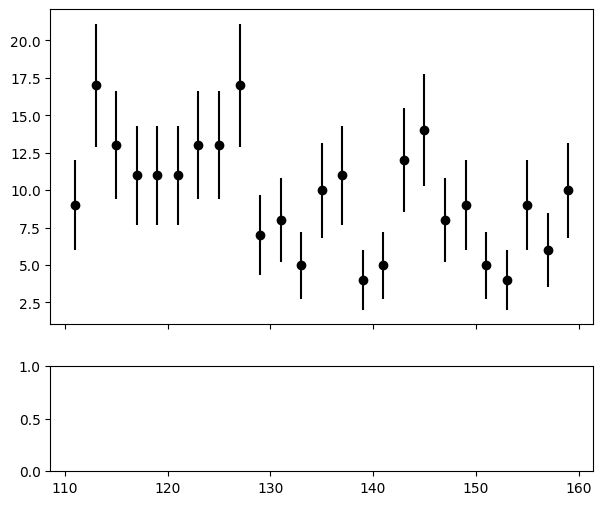

In [23]:
plot_data(data_all,True)

In [ ]:
!rm -rf IFIC-SummerSchool-2025
!git clone https://github.com/M0V1/IFIC-SummerSchool-2025.git
!pip install  numpy pandas uproot matplotlib mplhep awkward

In [ ]:
!ls IFIC-SummerSchool-2025
!find IFIC-SummerSchool-2025 -name "*.root"

In [ ]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from concurrent.futures import ProcessPoolExecutor, as_completed
import time

# Integrated luminosity in inverse picobarns
lumi = 36000.

In [ ]:
files = [
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.2J2LMET30.root",   #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_410471.PhPy8EG_A14_ttbar_hdamp258p75_allhad.2J2LMET30.root",     #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_345121.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaulm15hp20.2J2LMET30.root", #signal
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_345122.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaulp15hm20.2J2LMET30.root",#signal
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346343.PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_allhad.2J2LMET30.root",
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700792.Sh_2214_Ztautau_maxHTpTV2_BFilter.2J2LMET30.root",     #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_data15_periodF.2J2LMET30.root",  #data
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_346344.PhPy8EG_A14NNPDF23_NNPDF30ME_ttH125_semilep.2J2LMET30.root", #signal
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_data15_periodD.2J2LMET30.root",  #data
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_data15_periodH.2J2LMET30.root",  #data
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700902.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CFilterBVeto.2J2LMET30.root", #bkg
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_345120.PowhegPy8EG_NNLOPS_nnlo_30_ggH125_tautaul13l7.2J2LMET30.root",
    "IFIC-SummerSchool-2025/ODEO_FEB2025_v0_2J2LMET30_mc_700901.Sh_2214_Ztt_maxHTpTV2_Mll10_40_BFilter.2J2LMET30.root" #bkg
]

tree_name = "analysis"


In [ ]:
def calc_weight(data):
    weight_list = (data["ScaleFactor_TAU"] * data["ScaleFactor_DiTauTRIGGER"] * data["ScaleFactor_PILEUP"] *
                   (data["ScaleFactor_BTAG"] * data["mcWeight"] / data["sum_of_weights"]) *
                   (data["xsec"] * data["filteff"] * data["kfac"] * lumi))
    return weight_list

In [ ]:
def cut_trig(trigDT):
    return trigDT

def cut_met_et(met_et):
    return met_et > 20

def cut_leading_jet(jet_pt):
    return ak.sum(jet_pt > 40, axis=1) >= 1
def cut_tau_pt(tau_pt):
    return ak.sum(tau_pt > 5, axis=1) >= 2

In [ ]:
def Hmass(E, pt, eta, phi):
    tau_E = ak.sum(E, axis=1)
    tau_px = ak.sum(pt * np.cos(phi), axis=1)
    tau_py = ak.sum(pt * np.sin(phi), axis=1)
    tau_pz = ak.sum(pt * np.tanh(eta), axis=1)
    Mass = np.sqrt(tau_E**2 - (tau_px**2 + tau_py**2 + tau_pz**2))
    return Mass


In [ ]:
def process_file(file_path, tree_name, loop):
    tree = uproot.open(f"{file_path}:{tree_name}")
    sample_data = []

    variables = ["tau_pt", "tau_eta", "tau_phi", "tau_e", "tau_charge", "trigT", "lep_isTrigMatched", "tau_n", "met", "lep_type", "lep_isMediumID", "lep_isLooseIso", "jet_e", "jet_pt", "jet_eta", "jet_phi", "jet_btag_quantile", "ScaleFactor_TAU", "ScaleFactor_DiTauTRIGGER", "ScaleFactor_PILEUP", "ScaleFactor_BTAG", "mcWeight", "sum_of_weights", "xsec", "filteff", "kfac"]

    for data in tree.iterate(variables, library="ak", entry_start=int(tree.num_entries * fraction * loop), entry_stop=int(tree.num_entries * fraction * (loop + 1))):
        data = data[cut_tau_pt(data.tau_pt)]
        data = data[cut_leading_jet(data.jet_pt)]
       # data = data[cut_trig(data.trigT)]
        data = data[cut_met_et(data.met)]
        data['Inv_mass'] = Hmass(data.tau_e, data.tau_pt, data.tau_eta, data.tau_phi)
        data['Weight'] = calc_weight(data)
        sample_data.append(data)

    return ak.concatenate(sample_data, axis=0)


In [ ]:
def parallel_analysis(file_list, tree_name):
    combined_data = []
    for file_path in file_list:
        with ProcessPoolExecutor() as executor:
            futures = {executor.submit(process_file, file_path, tree_name, i): i for i in range(10)}
            results = []
            for future in as_completed(futures):
                try:
                    results.append(future.result())
                except Exception as e:
                    print(f"Error in file {file_path}, loop {futures[future]}: {e}")
        if results:
            combined_data.append(ak.concatenate(results, axis=0))

    return ak.concatenate(combined_data, axis=0) if combined_data else ak.Array([])


In [ ]:
# Main analysis loop
start_all = time.time()
fraction = 1
print("The analysis has started")

bkg_files = [
    files[0],  # Ztt_maxHTpTV2_Mll10_40_CVetoBVeto
    files[1],  # ttbar_allhad
    files[5],  # Ztautau_maxHTpTV2_BFilter
    files[10], # Ztt_maxHTpTV2_CFilterBVeto
    files[12]  # Ztt_maxHTpTV2_BFilter
]

signal_files = [
    files[2],  # ggH125_tautaulm15hp20
    files[3],  # ggH125_tautaulp15hm20
    files[11], # ggH125_tautaul13l7
    files[4],  # ttH125_allhad
    files[7],  # ttH125_semilep
]

data_files = [
   # files[6],  # data15_periodF
   # files[8],  # data15_periodD
    files[9],  # data15_periodH
]

bkg_data = parallel_analysis(bkg_files, tree_name)
signal_data = parallel_analysis(signal_files, tree_name)
data_data = parallel_analysis(data_files, tree_name)


In [ ]:

def plot_data(bkg, signal, data, fit=True):
    xmin, xmax, step_size = 110, 160, 2
    bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2


    data_y, _ = np.histogram(data['Inv_mass'], bins=bin_edges)
    data_yerr = np.sqrt(data_y)


    bkg_y, _ = np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight'])
    signal_y, _ = np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight'])


    stacked_mc = np.vstack([bkg_y, signal_y])
    total_mc = np.sum(stacked_mc, axis=0)


    total_mc_err = np.sqrt(
        np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight']**2)[0] +
        np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight']**2)[0]
    )

    fig, (main_ax, ratio_ax) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    main_ax.errorbar(bin_centres, data_y, yerr=data_yerr, fmt='ko', label=f'Data ({sum(data_y)} entries)')


    main_ax.hist([bkg['Inv_mass'], signal['Inv_mass']],
                 bins=bin_edges,
                 weights=[bkg['Weight'], signal['Weight']],
                 stacked=True,
                 color=['cyan', 'red'],
                 label=[r'$Bkg$', r'$Signal$'])


    main_ax.bar(bin_centres, 2 * total_mc_err, alpha=0.5, bottom=total_mc - total_mc_err,
                color='none', hatch="////", width=step_size, label='Stat. unc.')

    main_ax.set_xlim(xmin, xmax)
    main_ax.set_ylim(0, max(max(data_y), max(total_mc)) * 1.5)
    main_ax.set_ylabel("Events")
    main_ax.text(0.05, 0.93, 'ATLAS Open Data', transform=main_ax.transAxes, fontsize=13)
    main_ax.text(0.05, 0.88, 'for education', transform=main_ax.transAxes, style='italic', fontsize=8)
    main_ax.text(0.05, 0.82, r'$\sqrt{s}=13$ TeV, 36 fb$^{-1}$', transform=main_ax.transAxes)
    main_ax.legend(frameon=False)


    ratio = data_y / total_mc
    ratio_err = ratio * np.sqrt((data_yerr / data_y)**2 + (total_mc_err / total_mc)**2)
    ratio_ax.errorbar(bin_centres, ratio, yerr=ratio_err, fmt='ko')
    ratio_ax.axhline(1, color='red', linestyle='--')
    ratio_ax.set_ylabel("Data / MC")
    ratio_ax.set_ylim(0.5, 1.5)
    ratio_ax.set_xlabel(r"$m_{\tau\tau}$ [GeV]")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    plt.show()


plot_data(bkg_data, signal_data, data_data)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy.optimize import curve_fit

# Gaussian
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

#polynomial
def poly2(x, a, b, c):
    return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def plot_data(bkg, signal, data, fit=True):
    xmin, xmax, step_size = 110, 160, 2
    bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

    data_y, _ = np.histogram(data['Inv_mass'], bins=bin_edges)
    data_yerr = np.sqrt(data_y)

    bkg_y, _ = np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight'])
    signal_y, _ = np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight'])

    stacked_mc = np.vstack([bkg_y, signal_y])
    total_mc = np.sum(stacked_mc, axis=0)

    total_mc_err = np.sqrt(
        np.histogram(bkg['Inv_mass'], bins=bin_edges, weights=bkg['Weight']**2)[0] +
        np.histogram(signal['Inv_mass'], bins=bin_edges, weights=signal['Weight']**2)[0]
    )

    fig, (main_ax, ratio_ax) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    main_ax.errorbar(bin_centres, data_y, yerr=data_yerr, fmt='ko', label=f'Data ({sum(data_y)} entries)')


    main_ax.hist([bkg['Inv_mass'], signal['Inv_mass']],
                 bins=bin_edges,
                 weights=[bkg['Weight'], signal['Weight']],
                 stacked=True,
                 color=['cyan', 'red'],
                 label=[r'$Bkg$', r'$Signal$'])

   #stat error
    main_ax.bar(bin_centres, 2 * total_mc_err, alpha=0.5, bottom=total_mc - total_mc_err,
                color='none', hatch="////", width=step_size, label='Stat. unc.')

    # Fit
    if fit:
        mask = data_y > 0
        try:
            popt, pcov = curve_fit(gaussian, bin_centres[mask], data_y[mask], p0=[max(data_y), 125, 10], sigma=data_yerr[mask])
            fit_curve = gaussian(bin_centres, *popt)
            main_ax.plot(bin_centres, fit_curve, 'm--', linewidth=2, label=f'Gaussian Fit\n$\mu$={popt[1]:.1f}, $\sigma$={popt[2]:.1f}')
        except RuntimeError:
            print("Fit failed: could not converge.")

        try:
            popt_poly, pcov_poly = curve_fit(poly2, bin_centres[mask], data_y[mask], sigma=data_yerr[mask])
            fit_poly_curve = poly2(bin_centres, *popt_poly)
            main_ax.plot(bin_centres, fit_poly_curve, 'g--', linewidth=2, label=f'Poly3 Fit')
        except RuntimeError:
            print("Polynomial fit failed.")

    main_ax.set_xlim(xmin, xmax)
    main_ax.set_ylim(0, max(max(data_y), max(total_mc)) * 1.5)
    main_ax.set_ylabel("Events")
    main_ax.text(0.05, 0.93, 'ATLAS Open Data', transform=main_ax.transAxes, fontsize=13)
    main_ax.text(0.05, 0.88, 'for education', transform=main_ax.transAxes, style='italic', fontsize=8)
    main_ax.text(0.05, 0.82, r'$\sqrt{s}=13$ TeV, 36 fb$^{-1}$', transform=main_ax.transAxes)
    main_ax.legend(frameon=False)

    ratio = data_y / total_mc
    ratio_err = ratio * np.sqrt((data_yerr / data_y)**2 + (total_mc_err / total_mc)**2)
    ratio_ax.errorbar(bin_centres, ratio, yerr=ratio_err, fmt='ko')
    ratio_ax.axhline(1, color='red', linestyle='--')
    ratio_ax.set_ylabel("Data / MC")
    ratio_ax.set_ylim(0.5, 3.5)
    ratio_ax.set_xlabel(r"$m_{\tau\tau}$ [GeV]")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)
    plt.show()

plot_data(bkg_data, signal_data, data_data)